# Strategies for reducing computational load



This tutorial covers two strategies for pruning the computational load of TPOT to decrease run time.

# Successive Halving

This idea was first tested with TPOT by Parmentier et al. in ["TPOT-SH: a Faster Optimization Algorithm to Solve the AutoML Problem on Large Datasets"](https://www.researchgate.net/profile/Laurent-Parmentier-4/publication/339263193_TPOT-SH_A_Faster_Optimization_Algorithm_to_Solve_the_AutoML_Problem_on_Large_Datasets/links/5e5fd8b8a6fdccbeba1c6a56/TPOT-SH-A-Faster-Optimization-Algorithm-to-Solve-the-AutoML-Problem-on-Large-Datasets.pdf). The algorithm operates in two stages. Initially, it trains early generations using a small data subset and a large population size. Later generations then evaluate a smaller set of promising pipelines on larger, or even full, data portions. This approach rapidly identifies top-performing pipeline configurations through initial rough evaluations, followed by more comprehensive assessments. More information on this strategy in Tutorial 8.

In this tutorial, we will cover the following parameters:

`population_size`

`initial_population_size`

`population_scaling`

`generations_until_end_population`

`budget_range`

`generations_until_end_budget`

`budget_scaling`

`stepwise_steps`

Population size is the number of individuals evaluated each generation. Budget refers to the proportion of data to sample. By manipulating these parameters, we can control how quickly the budget increases and how population size changes over time. Most often, this will be used to start the algorithm by evaluating a large number of pipelines on small subsets of the data to quickly narrow now best models, before later getting a better estimate with larger samples on fewer datasets. This can reduce overall computational cost by not spending as much time evaluating poor performing pipelines.

`population_size` determines the number of individuals to evalaute each generation. Sometimes we may want to evaluate more or fewer individuals in the earlier generations. The `initial_population_size` parameter specifies the starting size of the population. The population size will gradually move from `initial_population_size` to `population_size` over the course of `generations_until_end_population` generations. `population_scaling` dictates how fast that scaling takes place. The interpolation over `generations_until_end_population` is done stepwise with the number of steps specified by `stepwise_steps`.

The same process goes for the budget scaling. 



The following cell illustrates how the population size and budget change over time with the given settings. (Note that tpot happens to converge on this dataset fairly quickly, but we turn off early stop to get the full run. )

/opt/anaconda3/envs/tpotenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


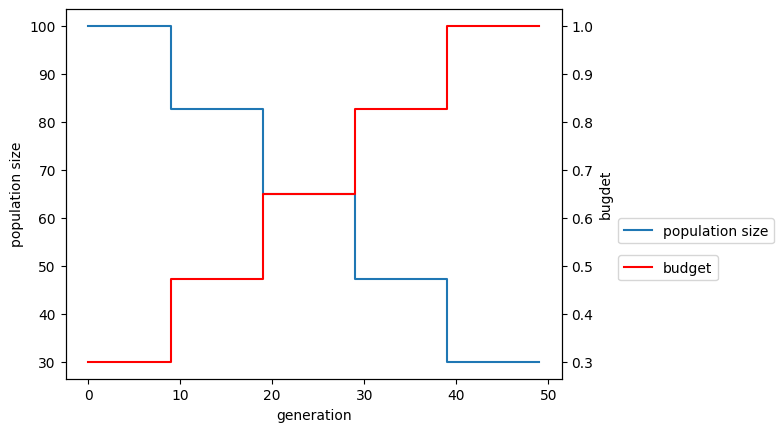

In [1]:
import matplotlib.pyplot as plt
import tpot

population_size=30
initial_population_size=100
population_scaling = .5
generations_until_end_population = 50

budget_range = [.3,1]
generations_until_end_budget=50
budget_scaling = .5
stepwise_steps = 5

#Population and budget use stepwise
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

interpolated_values_population = tpot.utils.beta_interpolation(start=initial_population_size, end=population_size, n=generations_until_end_population, n_steps=stepwise_steps, scale=population_scaling)
interpolated_values_budget = tpot.utils.beta_interpolation(start=budget_range[0], end=budget_range[1], n=generations_until_end_budget, n_steps=stepwise_steps, scale=budget_scaling)
ax1.step(list(range(len(interpolated_values_population))), interpolated_values_population, label=f"population size")
ax2.step(list(range(len(interpolated_values_budget))), interpolated_values_budget, label=f"budget", color='r')
ax1.set_xlabel("generation")
ax1.set_ylabel("population size")
ax2.set_ylabel("bugdet")

ax1.legend(loc='center left', bbox_to_anchor=(1.1, 0.4))
ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.3))
plt.show()


In [2]:
# A Graph pipeline starting with at least one selector as a leaf, potentially followed by a series
# of stacking classifiers or transformers, and ending with a classifier. The graph will have at most 15 nodes and a max depth of 6.

import tpot
import sklearn
import sklearn.datasets
import numpy as np
import time
import tpot
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import sklearn

X, y = sklearn.datasets.load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=1)
scorer = sklearn.metrics.make_scorer(sklearn.metrics.roc_auc_score, needs_proba=True, multi_class='ovr')


est = tpot.TPOTEstimator(
    generations=50,
    max_time_mins=None,
    scorers=['roc_auc_ovr'],
    scorers_weights=[1],
    classification=True,
    search_space = 'linear',
    n_jobs=32,
    cv=10,
    verbose=3,

    population_size=population_size,
    initial_population_size=initial_population_size,
    population_scaling = population_scaling,
    generations_until_end_population = generations_until_end_population,
    
    budget_range = budget_range,
    generations_until_end_budget=generations_until_end_budget,
    )



start = time.time()
est.fit(X_train, y_train)
print(f"total time: {time.time()-start}")

print("test score: ", scorer(est, X_test, y_test))

/opt/anaconda3/envs/tpotenv/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
Generation:   2%|▏         | 1/50 [00:20<16:51, 20.64s/it]

Generation:  1
Best roc_auc_score score: 1.0


Generation:   4%|▍         | 2/50 [00:45<18:39, 23.32s/it]

Generation:  2
Best roc_auc_score score: 1.0


Generation:   6%|▌         | 3/50 [01:19<22:03, 28.17s/it]

Generation:  3
Best roc_auc_score score: 1.0


Generation:   8%|▊         | 4/50 [01:57<24:30, 31.97s/it]

Generation:  4
Best roc_auc_score score: 1.0


Generation:  10%|█         | 5/50 [02:24<22:44, 30.32s/it]

Generation:  5
Best roc_auc_score score: 1.0


Generation:  12%|█▏        | 6/50 [03:09<25:40, 35.02s/it]

Generation:  6
Best roc_auc_score score: 1.0


Generation:  14%|█▍        | 7/50 [03:50<26:29, 36.96s/it]

Generation:  7
Best roc_auc_score score: 1.0


Generation:  16%|█▌        | 8/50 [04:27<26:04, 37.26s/it]

Generation:  8
Best roc_auc_score score: 1.0


Generation:  18%|█▊        | 9/50 [05:20<28:45, 42.08s/it]

Generation:  9
Best roc_auc_score score: 1.0


Generation:  20%|██        | 10/50 [06:03<28:09, 42.25s/it]

Generation:  10
Best roc_auc_score score: 1.0


Generation:  22%|██▏       | 11/50 [07:16<33:43, 51.88s/it]

Generation:  11
Best roc_auc_score score: 1.0


Generation:  24%|██▍       | 12/50 [08:04<31:55, 50.42s/it]

Generation:  12
Best roc_auc_score score: 1.0


Generation:  26%|██▌       | 13/50 [09:13<34:35, 56.10s/it]

Generation:  13
Best roc_auc_score score: 1.0


Generation:  28%|██▊       | 14/50 [10:15<34:49, 58.04s/it]

Generation:  14
Best roc_auc_score score: 1.0


Generation:  30%|███       | 15/50 [11:36<37:49, 64.85s/it]

Generation:  15
Best roc_auc_score score: 1.0


Generation:  32%|███▏      | 16/50 [12:59<39:47, 70.21s/it]

Generation:  16
Best roc_auc_score score: 1.0


Generation:  34%|███▍      | 17/50 [14:05<37:58, 69.05s/it]

Generation:  17
Best roc_auc_score score: 1.0


Generation:  36%|███▌      | 18/50 [15:23<38:13, 71.66s/it]

Generation:  18
Best roc_auc_score score: 1.0


Generation:  38%|███▊      | 19/50 [17:03<41:30, 80.33s/it]

Generation:  19
Best roc_auc_score score: 1.0


Generation:  40%|████      | 20/50 [18:32<41:28, 82.96s/it]

Generation:  20
Best roc_auc_score score: 1.0


Generation:  42%|████▏     | 21/50 [22:13<1:00:02, 124.23s/it]

Generation:  21
Best roc_auc_score score: 1.0


Generation:  44%|████▍     | 22/50 [24:54<1:03:11, 135.40s/it]

Generation:  22
Best roc_auc_score score: 1.0


Generation:  46%|████▌     | 23/50 [27:03<1:00:01, 133.40s/it]

Generation:  23
Best roc_auc_score score: 1.0


Generation:  48%|████▊     | 24/50 [29:09<56:48, 131.10s/it]  

Generation:  24
Best roc_auc_score score: 1.0


Generation:  50%|█████     | 25/50 [31:26<55:27, 133.09s/it]

Generation:  25
Best roc_auc_score score: 1.0


Generation:  52%|█████▏    | 26/50 [33:27<51:48, 129.50s/it]

Generation:  26
Best roc_auc_score score: 1.0


Generation:  54%|█████▍    | 27/50 [35:51<51:12, 133.60s/it]

Generation:  27
Best roc_auc_score score: 1.0


Generation:  56%|█████▌    | 28/50 [38:40<52:54, 144.28s/it]

Generation:  28
Best roc_auc_score score: 1.0


Generation:  58%|█████▊    | 29/50 [40:49<48:55, 139.80s/it]

Generation:  29
Best roc_auc_score score: 1.0


Generation:  60%|██████    | 30/50 [43:49<50:36, 151.83s/it]

Generation:  30
Best roc_auc_score score: 1.0


Generation:  62%|██████▏   | 31/50 [48:19<59:20, 187.37s/it]

Generation:  31
Best roc_auc_score score: 1.0


Generation:  64%|██████▍   | 32/50 [50:18<50:01, 166.77s/it]

Generation:  32
Best roc_auc_score score: 1.0


Generation:  66%|██████▌   | 33/50 [52:22<43:38, 154.01s/it]

Generation:  33
Best roc_auc_score score: 1.0


Generation:  68%|██████▊   | 34/50 [54:38<39:35, 148.46s/it]

Generation:  34
Best roc_auc_score score: 1.0


Generation:  70%|███████   | 35/50 [57:43<39:52, 159.52s/it]

Generation:  35
Best roc_auc_score score: 1.0


Generation:  72%|███████▏  | 36/50 [1:00:16<36:44, 157.44s/it]

Generation:  36
Best roc_auc_score score: 1.0


Generation:  74%|███████▍  | 37/50 [1:04:37<40:51, 188.57s/it]

Generation:  37
Best roc_auc_score score: 1.0


Generation:  76%|███████▌  | 38/50 [1:27:43<1:49:32, 547.68s/it]

Generation:  38
Best roc_auc_score score: 1.0


Generation:  78%|███████▊  | 39/50 [1:29:40<1:16:43, 418.49s/it]

Generation:  39
Best roc_auc_score score: 1.0


Generation:  80%|████████  | 40/50 [1:32:56<58:39, 351.95s/it]  

Generation:  40
Best roc_auc_score score: 1.0


Generation:  82%|████████▏ | 41/50 [1:36:55<47:41, 317.92s/it]

Generation:  41
Best roc_auc_score score: 1.0


Generation:  84%|████████▍ | 42/50 [1:38:54<34:27, 258.41s/it]

Generation:  42
Best roc_auc_score score: 1.0


Generation:  86%|████████▌ | 43/50 [1:40:59<25:28, 218.30s/it]

Generation:  43
Best roc_auc_score score: 1.0


Generation:  88%|████████▊ | 44/50 [1:42:38<18:14, 182.39s/it]

Generation:  44
Best roc_auc_score score: 1.0


Generation:  90%|█████████ | 45/50 [1:44:18<13:08, 157.68s/it]

Generation:  45
Best roc_auc_score score: 1.0


Generation:  92%|█████████▏| 46/50 [1:46:13<09:39, 144.91s/it]

Generation:  46
Best roc_auc_score score: 1.0


Generation:  94%|█████████▍| 47/50 [1:48:29<07:06, 142.24s/it]

Generation:  47
Best roc_auc_score score: 1.0


Generation:  96%|█████████▌| 48/50 [1:50:06<04:17, 128.67s/it]

Generation:  48
Best roc_auc_score score: 1.0


Generation:  98%|█████████▊| 49/50 [1:52:18<02:09, 129.85s/it]

Generation:  49
Best roc_auc_score score: 1.0


Generation: 100%|██████████| 50/50 [1:54:14<00:00, 137.09s/it]

Generation:  50
Best roc_auc_score score: 1.0


total time: 6862.724096059799
test score:  0.9917355371900827


## CV early pruning

Most often, we will be evaluating pipelines using cross validation. However, we can often tell within the first few folds whether or not the pipeline is going have a reasonable change of outperforming the previous best pipelines. For example, if the best score so far is .92 AUROC and the average score of the first five folds of our current pipeline is only around .61, we can be reasonably confident that the next five folds are unlikely to this pipeline ahead of the others. We can save a significant amount of compute by not computing the rest of the folds. There are two strategies that TPOT can use to accomplish this (More information on these strategies in Tutorial 8).
   1. Threshold Pruning: Pipelines must achieve a score above a predefined percentile threshold (based on previous pipeline scores) to proceed in each cross-validation (CV) fold.
   2. Selection Pruning: Within each population, only the top N% of pipelines (ranked by performance in the previous CV fold) are selected to evaluate in the next fold."


We can further reduce computational load by terminating the evaluation of individual pipelines early if the first few CV scores are not promising. Note that this is different than early stopping of the full algorithm. In this section we will cover:

`threshold_evaluation_pruning`

`threshold_evaluation_scaling`

`min_history_threshold`

`selection_evaluation_pruning`

`selection_evaluation_scaling`

Threshold early stopping uses previous scores to identify and terminate the cross validation evaluation of poorly performing pipelines. We calculate the percentile scores from the previously evaluated pipelines. A pipeline must reach the given percentile each fold for the next to be evaluated, otherwise the pipeline is discarded.

The `threshold_evaluation_pruning` parameter is a list that specifies the starting and ending percentiles to use as a threshold for the evaluation early stopping. W The `threshold_evaluation_scaling` parameter is a float that controls the rate at which the threshold moves from the start to end percentile. The `min_history_threshold` parameter specifies the minimum number of previous scores needed before using threshold early stopping. This ensures that the algorithm has enough historical data to make an informed decision about when to stop evaluating pipelines.

Selection early stopping uses a selection algorithm after each fold to select which algorithms will be evaluated for the next fold. For example, after evaluating 100 individuals on fold 1, we may want to only evaluate the best 50 for the remaining folds.

The `selection_evaluation_pruning` parameter is a list that specifies the lower and upper percentage of the population size to select each round of CV. This is used to determine which individuals to evaluate in the next generation. The `selection_evaluation_scaling` parameter is a float that controls the rate at which the selection threshold moves from the start to end percentile.

By manipulating these parameters, we can control how the algorithm selects individuals to evaluate in the next generation and when to stop evaluating pipelines that are not performing well.

In practice, the values of these parameters will depend on the specific problem and the available computational resources. 

In the following sections, we will show you how to set and manipulate these parameters using Python code in a Jupyter Notebook. We will also provide examples of how these parameters can affect the performance of the algorithm.

(Note that in these small test cases, you may not notice much or any performance improvements, these are more likely to be more beneficial in real world scenarios with larger datasets and slower evaluating pipelines.)

**Considerations:**
It is important to be aware of how CV pruning interacts with the evolutionary algorithm. When pipelines are pruned with one of these methods, they are removed from the live population and thus are no longer used to inform the TPOT algorithm. If too many pipelines are pruned, this could reduce the diversity of pipelines per generation, and limit TPOT's ability to learn. Additionally, the pruning methods may interact with how long it takes TPOT to run. If the pruning algorithm removes the slightly less performant but faster running pipelines, TPOT will most likely fill the next generation with only slower running pipelines, thus technically increasing the total runtime. This may be acceptable since more compute is dedicated to the higher performing pipelines.

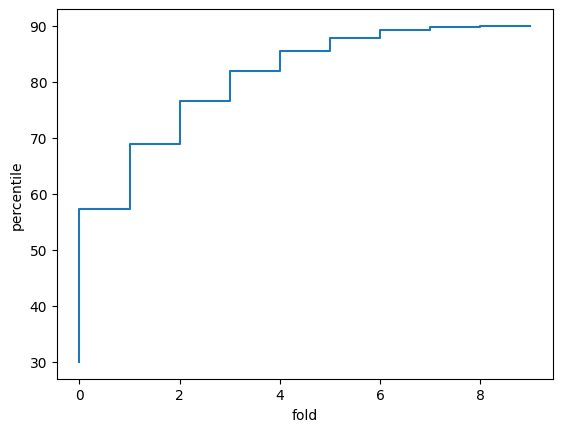

In [3]:
import matplotlib.pyplot as plt
import tpot
import time
import sklearn
import sklearn.datasets

threshold_evaluation_pruning = [30, 90]
threshold_evaluation_scaling = .2 #.5
cv = 10

#Population and budget use stepwise
fig, ax1 = plt.subplots()

interpolated_values = tpot.utils.beta_interpolation(start=threshold_evaluation_pruning[0], end=threshold_evaluation_pruning[-1], n=cv, n_steps=cv, scale=threshold_evaluation_scaling)
ax1.step(list(range(len(interpolated_values))), interpolated_values, label=f"threshold")
ax1.set_xlabel("fold")
ax1.set_ylabel("percentile")
#ax1.legend(loc='center left', bbox_to_anchor=(1.1, 0.4))
plt.show()


In [4]:
import tpot
from tpot.search_spaces.pipelines import *
from tpot.search_spaces.nodes import *
from tpot.config.get_configspace import get_search_space
import sklearn.model_selection
import sklearn


selectors = get_search_space(["selectors","selectors_classification", "Passthrough"], random_state=42,)
estimators = get_search_space(['XGBClassifier'],random_state=42,)

scalers = get_search_space(["scalers","Passthrough"],random_state=42,)

transformers_layer =UnionPipeline([
                        ChoicePipeline([
                            DynamicUnionPipeline(get_search_space(["transformers"], random_state=42,)),
                            get_search_space("SkipTransformer"),
                        ]),
                        get_search_space("Passthrough")
                        ]
                    )
    
search_space = SequentialPipeline(search_spaces=[
                                            scalers,
                                            selectors, 
                                            transformers_layer,
                                            estimators,
                                            ])

In [5]:
import matplotlib.pyplot as plt
import tpot
import time
import sklearn
import sklearn.datasets

scorer = sklearn.metrics.make_scorer(sklearn.metrics.roc_auc_score, needs_proba=True, multi_class='ovr')

X, y = sklearn.datasets.make_classification(n_samples=5000, n_features=20, n_classes=5, random_state=1, n_informative=15, n_redundant=5, n_repeated=0, n_clusters_per_class=3, class_sep=.8)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=1)

# search_space = tpot.config.template_search_spaces.get_template_search_spaces("linear",inner_predictors=False, random_state=42)


/opt/anaconda3/envs/tpotenv/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [6]:
# no pruning
est = tpot.TPOTEstimator(  
                            generations=10,
                            max_time_mins=None,
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            classification=True,
                            search_space = search_space,
                            population_size=100,
                            n_jobs=32,
                            cv=cv,
                            verbose=3,
                            random_state=42,
                            )


start = time.time()
est.fit(X_train, y_train)
print(f"total time: {time.time()-start}")
print("test score: ", scorer(est, X_test, y_test))

Generation:  10%|█         | 1/10 [02:42<24:26, 162.98s/it]

Generation:  1
Best roc_auc_score score: 0.9212394545585599


Generation:  20%|██        | 2/10 [06:10<25:14, 189.31s/it]

Generation:  2
Best roc_auc_score score: 0.921316057689257


Generation:  30%|███       | 3/10 [10:07<24:37, 211.00s/it]

Generation:  3
Best roc_auc_score score: 0.9291812014325632


Generation:  40%|████      | 4/10 [16:26<27:43, 277.33s/it]

Generation:  4
Best roc_auc_score score: 0.9291812014325632


Generation:  50%|█████     | 5/10 [21:24<23:44, 284.90s/it]

Generation:  5
Best roc_auc_score score: 0.9309353469187138


Generation:  60%|██████    | 6/10 [28:02<21:32, 323.19s/it]

Generation:  6
Best roc_auc_score score: 0.9328394699598583


Generation:  70%|███████   | 7/10 [36:02<18:43, 374.57s/it]

Generation:  7
Best roc_auc_score score: 0.9341963775600117


Generation:  80%|████████  | 8/10 [45:34<14:34, 437.41s/it]

Generation:  8
Best roc_auc_score score: 0.9341963775600117


Generation:  90%|█████████ | 9/10 [54:40<07:51, 471.27s/it]

Generation:  9
Best roc_auc_score score: 0.9356175936945494


Generation: 100%|██████████| 10/10 [1:03:45<00:00, 382.55s/it]

Generation:  10
Best roc_auc_score score: 0.9371852416832148


total time: 3836.4180731773376
test score:  0.9422368174356803


In [7]:
import tpot.config
import tpot.config.template_search_spaces
import tpot.search_spaces



# search_space = tpot.config.get_search_space(["RandomForestClassifier"])

est = tpot.TPOTEstimator(  
                            generations=10,
                            max_time_mins=None,
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            classification=True,
                            search_space = search_space,
                            population_size=100,
                            n_jobs=32,
                            cv=cv,
                            verbose=3,
                            random_state=42,

                            threshold_evaluation_pruning = threshold_evaluation_pruning,
                            threshold_evaluation_scaling = threshold_evaluation_scaling,
                            )


start = time.time()
est.fit(X_train, y_train)
print(f"total time: {time.time()-start}")
print("test score: ", scorer(est, X_test, y_test))

Generation:  10%|█         | 1/10 [02:57<26:40, 177.87s/it]

Generation:  1
Best roc_auc_score score: 0.9212394545585602


Generation:  20%|██        | 2/10 [03:57<14:24, 108.05s/it]

Generation:  2
Best roc_auc_score score: 0.9212394545585602


Generation:  30%|███       | 3/10 [05:58<13:18, 114.13s/it]

Generation:  3
Best roc_auc_score score: 0.9212394545585602


Generation:  40%|████      | 4/10 [07:54<11:29, 114.96s/it]

Generation:  4
Best roc_auc_score score: 0.9212394545585602


Generation:  50%|█████     | 5/10 [10:43<11:11, 134.34s/it]

Generation:  5
Best roc_auc_score score: 0.921316057689257


Generation:  60%|██████    | 6/10 [13:16<09:23, 140.78s/it]

Generation:  6
Best roc_auc_score score: 0.921316057689257


Generation:  70%|███████   | 7/10 [15:05<06:31, 130.43s/it]

Generation:  7
Best roc_auc_score score: 0.921316057689257


Generation:  80%|████████  | 8/10 [18:01<04:49, 144.72s/it]

Generation:  8
Best roc_auc_score score: 0.9255953925256337


Generation:  90%|█████████ | 9/10 [19:53<02:14, 134.59s/it]

Generation:  9
Best roc_auc_score score: 0.9255953925256337


Generation: 100%|██████████| 10/10 [21:24<00:00, 128.50s/it]

Generation:  10
Best roc_auc_score score: 0.9255953925256337


total time: 1295.825649023056
test score:  0.9320499022897322


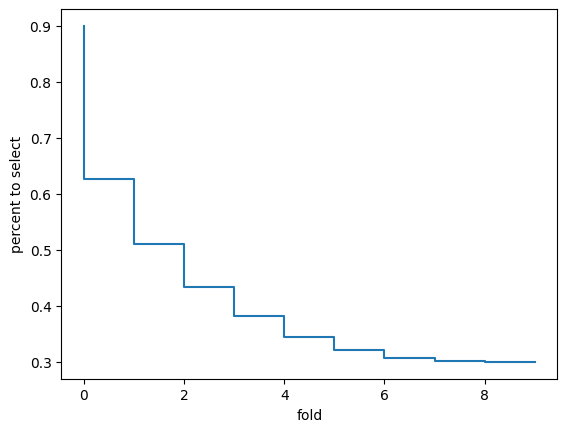

In [8]:
import matplotlib.pyplot as plt
import tpot

selection_evaluation_pruning = [.9, .3]
selection_evaluation_scaling = .2

#Population and budget use stepwise
fig, ax1 = plt.subplots()

interpolated_values = tpot.utils.beta_interpolation(start=selection_evaluation_pruning[0], end=selection_evaluation_pruning[-1], n=cv, n_steps=cv, scale=selection_evaluation_scaling)
ax1.step(list(range(len(interpolated_values))), interpolated_values, label=f"threshold")
ax1.set_xlabel("fold")
ax1.set_ylabel("percent to select")
#ax1.legend(loc='center left', bbox_to_anchor=(1.1, 0.4))
plt.show()


In [9]:
est = tpot.TPOTEstimator(  
                            generations=10,
                            max_time_mins=None,
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            classification=True,
                            search_space = search_space,
                            population_size=100,
                            n_jobs=32,
                            cv=cv,
                            verbose=3,
                            random_state=42,

                            selection_evaluation_pruning  = selection_evaluation_pruning,
                            selection_evaluation_scaling = selection_evaluation_scaling,
                            )


start = time.time()
est.fit(X_train, y_train)
print(f"total time: {time.time()-start}")
print("test score: ", scorer(est, X_test, y_test))

Generation:  10%|█         | 1/10 [02:23<21:31, 143.50s/it]

Generation:  1
Best roc_auc_score score: 0.9212394545585602


Generation:  20%|██        | 2/10 [04:00<15:30, 116.31s/it]

Generation:  2
Best roc_auc_score score: 0.9212394545585602


Generation:  30%|███       | 3/10 [05:42<12:48, 109.73s/it]

Generation:  3
Best roc_auc_score score: 0.9212394545585602


Generation:  40%|████      | 4/10 [07:36<11:08, 111.45s/it]

Generation:  4
Best roc_auc_score score: 0.9212394545585602


Generation:  50%|█████     | 5/10 [09:12<08:48, 105.72s/it]

Generation:  5
Best roc_auc_score score: 0.9212394545585602


Generation:  60%|██████    | 6/10 [11:04<07:11, 107.81s/it]

Generation:  6
Best roc_auc_score score: 0.9212394545585602


Generation:  70%|███████   | 7/10 [12:54<05:26, 108.71s/it]

Generation:  7
Best roc_auc_score score: 0.9212394545585602


Generation:  80%|████████  | 8/10 [14:45<03:38, 109.49s/it]

Generation:  8
Best roc_auc_score score: 0.925549420935039


Generation:  90%|█████████ | 9/10 [16:49<01:54, 114.03s/it]

Generation:  9
Best roc_auc_score score: 0.925549420935039


Generation: 100%|██████████| 10/10 [18:36<00:00, 111.67s/it]

Generation:  10
Best roc_auc_score score: 0.925549420935039



/opt/anaconda3/envs/tpotenv/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:595: UserWarning: n_components is too large: it will be set to 20
  warnings.warn(
/opt/anaconda3/envs/tpotenv/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


total time: 1129.1526980400085
test score:  0.9324219154371735


In [10]:
est.evaluated_individuals[est.evaluated_individuals['roc_auc_score_step_9']>0]

,roc_auc_score,Parents,Variation_Function,Individual,Generation,roc_auc_score_step_0,Submitted Timestamp,Completed Timestamp,Eval Error,roc_auc_score_step_1,roc_auc_score_step_2,roc_auc_score_step_3,roc_auc_score_step_4,roc_auc_score_step_5,roc_auc_score_step_6,roc_auc_score_step_7,roc_auc_score_step_8,roc_auc_score_step_9,Pareto_Front,Instance
0,0.812263,NaN,NaN,<tpot.search_spaces.pipelines.sequential.Seque...,0.0,0.811153,1.740198e+09,1.740198e+09,None,0.799213,0.807710,0.813587,0.797528,0.820692,0.827614,0.815069,0.805447,0.824616,NaN,"(MinMaxScaler(), RFE(estimator=ExtraTreesClass..."
1,0.848068,NaN,NaN,<tpot.search_spaces.pipelines.sequential.Seque...,0.0,0.846478,1.740197e+09,1.740197e+09,None,0.839894,0.844619,0.848321,0.846915,0.857902,0.855875,0.827655,0.850938,0.862081,NaN,"(Passthrough(), RFE(estimator=ExtraTreesClassi..."
4,0.831502,NaN,NaN,<tpot.search_spaces.pipelines.sequential.Seque...,0.0,0.817219,1.740197e+09,1.740197e+09,None,0.827888,0.821911,0.825558,0.830020,0.831529,0.836955,0.844634,0.832499,0.846805,NaN,"(StandardScaler(), VarianceThreshold(threshold..."
5,0.830374,NaN,NaN,<tpot.search_spaces.pipelines.sequential.Seque...,0.0,0.817150,1.740197e+09,1.740197e+09,None,0.831885,0.820694,0.824899,0.824409,0.827861,0.833923,0.844308,0.832798,0.845818,NaN,"(MinMaxScaler(), SelectFromModel(estimator=Ext..."
6,0.850091,NaN,NaN,<tpot.search_spaces.pipelines.sequential.Seque...,0.0,0.843524,1.740197e+09,1.740197e+09,None,0.841176,0.840619,0.846209,0.849561,0.854367,0.858035,0.860165,0.845179,0.862077,NaN,"(Normalizer(norm='max'), SelectFwe(alpha=0.000..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,0.886974,"(13, 13)",ind_mutate,<tpot.search_spaces.pipelines.sequential.Seque...,9.0,0.871580,1.740198e+09,1.740198e+09,None,0.887762,0.882504,0.860872,0.898100,0.885523,0.893527,0.904779,0.884557,0.900537,NaN,"(StandardScaler(), SelectFromModel(estimator=E..."
986,0.850281,"(35, 470)",ind_crossover,<tpot.search_spaces.pipelines.sequential.Seque...,9.0,0.837493,1.740198e+09,1.740198e+09,None,0.858289,0.844141,0.851260,0.848909,0.853002,0.856132,0.845356,0.847830,0.860393,NaN,"(StandardScaler(), SelectPercentile(percentile..."
990,0.878811,"(866, 866)",ind_mutate,<tpot.search_spaces.pipelines.sequential.Seque...,9.0,0.875842,1.740198e+09,1.740198e+09,None,0.862567,0.881858,0.885539,0.874347,0.888858,0.891205,0.882103,0.863952,0.881838,NaN,"(Normalizer(norm='l1'), SelectPercentile(perce..."
991,0.835669,"(72, 855)",ind_crossover,<tpot.search_spaces.pipelines.sequential.Seque...,9.0,0.838375,1.740198e+09,1.740198e+09,None,0.844572,0.837234,0.822799,0.818868,0.840971,0.845122,0.816390,0.840709,0.851650,NaN,"(MinMaxScaler(), SelectPercentile(percentile=4..."


All of the above methods can be used independently or simultaneously as done below:

In [12]:
est = tpot.TPOTEstimator(  
                            generations=10,
                            max_time_mins=None,
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            classification=True,
                            search_space = search_space,
                            population_size=30,
                            n_jobs=3,
                            cv=cv,
                            verbose=3,

                            initial_population_size=initial_population_size,
                            population_scaling = population_scaling,
                            generations_until_end_population = generations_until_end_population,
                            
                            budget_range = budget_range,
                            generations_until_end_budget=generations_until_end_budget,
                            
                            threshold_evaluation_pruning = threshold_evaluation_pruning,
                            threshold_evaluation_scaling = threshold_evaluation_scaling,

                            selection_evaluation_pruning  = selection_evaluation_pruning,
                            selection_evaluation_scaling = selection_evaluation_scaling,
                            )


start = time.time()
est.fit(X_train, y_train)
print(f"total time: {time.time()-start}")
print("test score: ", scorer(est, X_test, y_test))

Generation:  10%|█         | 1/10 [01:34<14:09, 94.40s/it]

Generation:  1
Best roc_auc_score score: 0.8515086951804098


Generation:  20%|██        | 2/10 [02:26<09:14, 69.36s/it]

Generation:  2
Best roc_auc_score score: 0.8515086951804098


Generation:  30%|███       | 3/10 [03:41<08:23, 71.97s/it]

Generation:  3
Best roc_auc_score score: 0.8515086951804098


Generation:  40%|████      | 4/10 [04:52<07:09, 71.53s/it]

Generation:  4
Best roc_auc_score score: 0.8515086951804098


Generation:  50%|█████     | 5/10 [05:52<05:37, 67.57s/it]

Generation:  5
Best roc_auc_score score: 0.8515086951804098


Generation:  60%|██████    | 6/10 [07:13<04:48, 72.10s/it]

Generation:  6
Best roc_auc_score score: 0.8515086951804098


Generation:  70%|███████   | 7/10 [08:06<03:17, 65.84s/it]

Generation:  7
Best roc_auc_score score: 0.8515086951804098


Generation:  80%|████████  | 8/10 [08:57<02:02, 61.13s/it]

Generation:  8
Best roc_auc_score score: 0.8515086951804098


Generation:  90%|█████████ | 9/10 [09:39<00:55, 55.14s/it]

Generation:  9
Best roc_auc_score score: 0.8515086951804098


Generation: 100%|██████████| 10/10 [10:17<00:00, 61.70s/it]

Generation:  10
Best roc_auc_score score: 0.8515086951804098


total time: 621.607882976532
test score:  0.9084772293865335
